In [ ]:
!pip install scipy tenacity tiktoken termcolor openai requests openpyxl langchain faiss-cpu

In [2]:
import json
import time
import os
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
import pandas as pd
import csv
import glob
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.chains.llm import LLMChain
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.agents import Tool
from langchain.agents import initialize_agent

In [3]:
from langchain.document_loaders import UnstructuredExcelLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
embed_model = 'text-embedding-ada-002'
DB_path = "/content/drive/MyDrive/人工知能演習/コンピュータアーキテクチャDB.csv"
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [26]:
embed = OpenAIEmbeddings( model='text-embedding-ada-002')

In [27]:
# 内容のみで実行したいときにこのセルを動かす

# CSV ファイルから 2 列目のみを読み込む
data1 = pd.read_csv(DB_path)
second_column_data = data1["テーマ"]
data1 = data1["内容"]

data1.to_csv('output.csv', index=False, encoding='utf-8')
DB_path = '/content/output.csv'

In [8]:
loaders = []
data = []
loader = CSVLoader(DB_path, encoding='utf-8')
data.extend(loader.load())

In [10]:
#FAISSはベクトルDB:dbが作成された
db = FAISS.from_documents(data, embed)

In [11]:
def ask_database(query, db=db, threshold=0.4):
	#.similarity_search_with_scoreは取得物とともにスコアを返す
	#デフォルトはL2キョリ(コサイン類似度とかにもできるらしい？)
	docs_and_scores = db.similarity_search_with_score(query)
	retrieved_doc_text = []

	for i, (doc, score) in enumerate(docs_and_scores):
		if score < threshold:
			retrieved_doc_text.append(doc.page_content)

	return retrieved_doc_text if retrieved_doc_text else "不明確です"

In [12]:
db.save_local("db.faiss")

In [13]:
import faiss
db_faiss = faiss.read_index('db.faiss/index.faiss')

In [14]:
n = db_faiss.ntotal  # データベースに保存されているベクトルの数
dimension = db_faiss.d  # ベクトルの次元
vectors = db_faiss.reconstruct_n(0, n)  # すべてのベクトルを抽出

# 2. ベクトルをpandasのDataFrameに変換
df = pd.DataFrame(vectors)

# 3. DataFrameをCSV形式で保存
csv_path = "faiss_vectors.csv"
df.to_csv(csv_path, index=False)

In [15]:
print(ask_database("DRAMとは何か？"))

['内容: DRAMはデータの保持のためにプリチャージとリフレッシュが必要であり,アクセスも複雑である.しかし,DRAMは容量がSRAMの4倍以上と大きく,高速化のための工夫も進んでいるため,コンビュータの主記憶などとして広く使われている.図2.1の「主記憶装置」もDRAMである場合がほとんどである。', '内容: SRAMはDRAMと違って,リフレッシュなどをしなくても,電源を供給しているだけでデータが保持される.SRAMは記憶回路の設計が楽であり,動作もDRAMに比べて速いが,一方でDRAMより実装規模が大きい(典型的には4倍)という欠点がある.SRAMは,高速動作が必要な小容量の記憶媒体として使われる.', '内容: メモリは,読出しだけができるROM(read only memory)と,読み書きの両方ができるRAM(random access memory)に大別される.', '内容: 図2.4には5種類のDRAMについて示している.このうち,SDRAM(synchronous DRAM)とRDRAM(rambus DRAM)が現在の主流となっている.']


In [16]:
# FAISS内のベクトルを可視化
import pandas as pd
import numpy as np


In [18]:
from sklearn.manifold import TSNE
from ast import literal_eval

datafile_path = "faiss_vectors.csv"
df = pd.read_csv(datafile_path)
matrix = np.array(df.values.tolist())
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(58, 2)

In [19]:
# x成分とy成分を抜き出す
# ベクトルを2つのリストに分解: x_coords と y_coords
x_components, y_components = zip(*vis_dims)

In [ ]:
import csv

# 結果を保存するための空のリストを作成
first_column_data = []

# CSVファイルを開く
with open(DB_path, 'r') as csvfile:
    reader = csv.reader(csvfile)

    # 最初の行をスキップ
    next(reader)

    # 1列目のデータをリストに追加
    for row in reader:
        first_column_data.append(row[0])

print(first_column_data)

In [ ]:
# 結果を保存するための空のリストを作成
second_column_data = []

# CSVファイルを開く
with open(DB_path, 'r') as csvfile:
    reader = csv.reader(csvfile)

    # 最初の行をスキップ
    next(reader)

    # 1列目のデータをリストに追加
    for row in reader:
        second_column_data.append(row[1])

print(second_column_data)

In [28]:
df["x_components"] = x_components
df["y_components"] = y_components
# df["theme"] = first_column_data
# df["context"] = second_column_data
# 一時的に
df["context"] = first_column_data
df["theme"] = second_column_data
df = df[["x_components","y_components","theme","context"]]
df.head()

,x_components,y_components,theme,context
0,16.003216,-75.822517,主記憶装置,"コンピュータの基本はALUとレジスタの間のデータの流れにある.データが正しく流れ,整形される..."
1,-2.553304,-83.290512,レジスタとALUだけでは計算できない,"1章でコンビュータの演算のサイクルについて学んだ.レジスタからデータを取り出し,これをALU..."
2,-26.832985,-81.558197,レジスタとALUだけでは計算できない,"図1.13を観察すると,これまで学んだことに対して次のような疑間が浮かぶだろう.\n①コンピ..."
3,15.982110,-55.911037,主記憶装置,"フリップフロップは最も基本的な1ビットのメモリであり,これを並べたレジスタは一語のメモリであ..."
4,67.510513,-79.463814,主記憶装置,"われわれのコンピュータでは,レジスタの外側に主記憶装置(mainmemory)と呼ばれる容量..."


In [ ]:
!pip install japanize-matplotlib

import japanize_matplotlib
import matplotlib.pyplot as plt

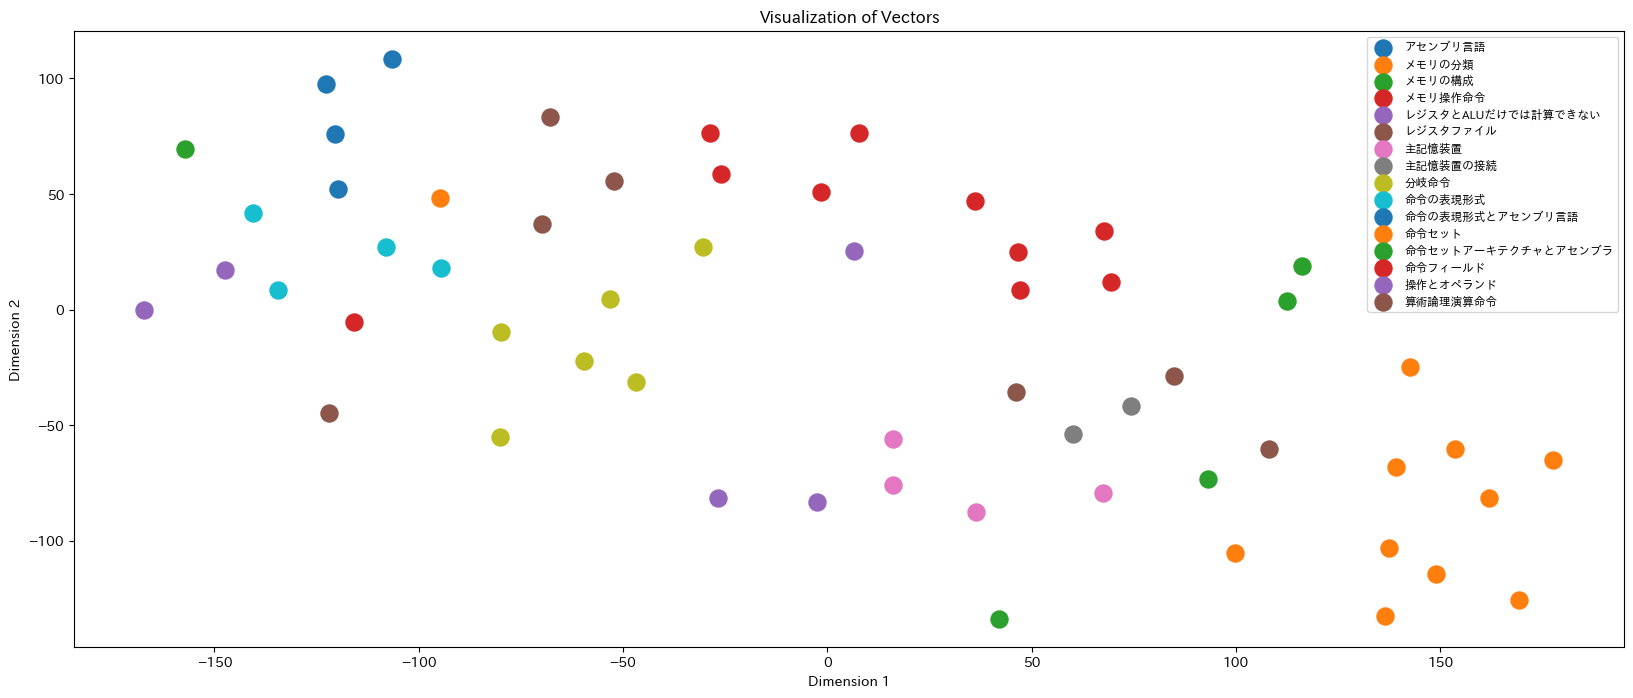

In [33]:
import matplotlib
import numpy as np

# プロット
plt.figure(figsize=(20, 8))
for theme, group in df.groupby('theme'):
    plt.scatter(group['x_components'],group['y_components'], label=theme, s=150)

# グラフのタイトルと軸ラベルを設定
plt.title("Visualization of Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='best',fontsize='small')
# plt.grid(True)
# plt.tight_layout()
plt.show()